In [4]:
#pip install torch==2.3.1 
#pip install transformers==4.41.3 --progress-bar off
#pip install datasets==2.20.0 --progress-bar off
#pip install accelerate==0.31.0 --progress-bar off
#pip install bitsandbytes==0.43.1 --progress-bar off
#pip install peft==0.11.1 --progress-bar off
#pip install trl==0.9.4 --progress-bar off
#pip install colored==2.2.4 --progress-bar off

In [5]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
NEW_MODEL = "Llama-3-8B-Instruct-Finance-RAG"

In [7]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

C:\Users\Overa\anaconda3\envs\test_env\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Overa\.cache\huggingface\hub\models--meta-llama--Meta-Llama-3-8B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Embedding(128264, 4096)

In [8]:
# prints out the config of the mode
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
 

In [9]:
tokenizer.bos_token, tokenizer.bos_token_id

('<|begin_of_text|>', 128000)

In [10]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|eot_id|>', 128009)

In [11]:
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 128256)

In [12]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

128256

In [13]:
dataset = load_dataset("virattt/financial-qa-10K")
dataset

README.md:   0%|          | 0.00/419 [00:00<?, ?B/s]

C:\Users\Overa\anaconda3\envs\test_env\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Overa\.cache\huggingface\hub\datasets--virattt--financial-qa-10K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

In [14]:
rows = []
for item in dataset["train"]:
    rows.append(
        {
            "question": item["question"],
            "context": item["context"],
            "answer": item["answer"],
        }
    )
df = pd.DataFrame(rows)
df.head()

,question,context,answer
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...


In [15]:
#null value checker
df.isnull().value_counts()

question  context  answer
False     False    False     7000
Name: count, dtype: int64

In [16]:
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [17]:
df["text"] = df.apply(format_example, axis=1)

In [18]:

def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [19]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [20]:
df.head()

,question,context,answer,text,token_count
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.,<|begin_of_text|><|start_header_id|>system<|en...,76
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...,<|begin_of_text|><|start_header_id|>system<|en...,172
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.,<|begin_of_text|><|start_header_id|>system<|en...,74
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...,<|begin_of_text|><|start_header_id|>system<|en...,98
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...,<|begin_of_text|><|start_header_id|>system<|en...,84


In [21]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What area did NVIDIA initially focus on before expanding to other computationally intensive fields?

Information:

```
Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

NVIDIA initially focused on PC graphics.<|eot_id|>


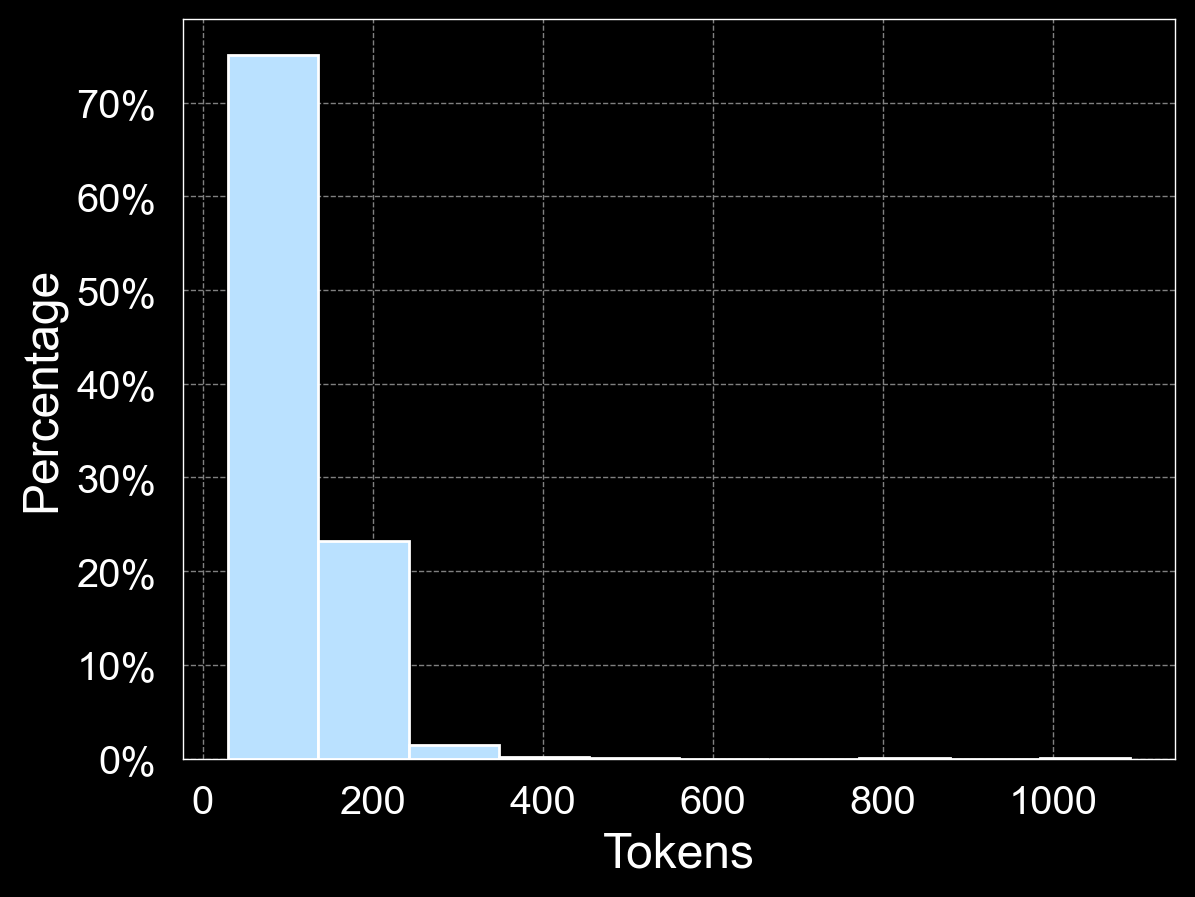

In [22]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show();

In [23]:
len(df[df.token_count < 512]), len(df), len(df[df.token_count < 512]) / len(df)

(6997, 7000, 0.9995714285714286)

In [24]:
df = df[df.token_count < 512]
df = df.sample(6000)
df.shape

(6000, 5)

In [25]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

In [26]:
len(train) / len(df), len(val) / len(df), len(test) / len(df)

(0.8, 0.16, 0.04)

In [27]:
len(train), len(val), len(test)

(4800, 960, 240)

In [28]:
train.sample(n=4000).to_json("train.json", orient="records", lines=True)
val.sample(n=500).to_json("val.json", orient="records", lines=True)
test.sample(n=100).to_json("test.json", orient="records", lines=True)

In [29]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 500
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 100
    })
})

In [31]:
print(dataset["train"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the impact of the new $1.25 price point on Dollar Tree’s sales units and profitability?

Information:

```
To date, the increase in the price point has more than offset the decline in the number of units sold.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The increase to a $1.25 price point at Dollar Tree stores has more than offset the decline in the number of units sold, suggesting a positive impact on profitability.<|eot_id|>


In [32]:
#### Test Original Model ####
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

In [33]:
def create_test_prompt(data_row):
    prompt = dedent(
        f"""
    {data_row["question"]}

    Information:

    ```
    {data_row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False
    )

In [34]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What are the operating segments of the company in Macao?

Information:

```
Our operating segments in Macao consist of The Venetian Macao; The Londoner Macao; The Parisian Macao; The Plaza Macao and Four Seasons Macao; and the Sands Macao.
```<|eot_id|>


In [35]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

C:\Users\Overa\anaconda3\envs\test_env\lib\site-packages\transformers\models\llama\modeling_llama.py:660: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



answer:     The operating segments in Macao consist of The Venetian Macao, The Londoner Macao, The Parisian Macao, The Plaza Macao and Four Seasons Macao, and the Sands Macao.
prediction: assistant

The operating segments of the company in Macao are:

1. The Venetian Macao
2. The Londoner Macao
3. The Parisian Macao
4. The Plaza Macao
5. Four Seasons Macao
6. Sands Macao

CPU times: total: 2.92 s
Wall time: 5.02 s


In [36]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

How much did the company's net earnings amount to in fiscal 2022?

Information:

```
Net earnings were $17.1 billion in fiscal 2022.
```<|eot_id|>


In [37]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     $17.1 billion
prediction: assistant

The company's net earnings in fiscal 2022 were $17.1 billion.

CPU times: total: 859 ms
Wall time: 1.68 s


In [38]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the interest rate applicable to draws under the Term Loan as mentioned?

Information:

```
Draws under the Term Loan bear interest on the principal amount outstanding at Term SOFR plus an applicable margin, currently 5.46%, plus a credit spread adjustment.
```<|eot_id|>


In [39]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     5.46%
prediction: assistant

The interest rate applicable to draws under the Term Loan is the sum of:

1. Term SOFR
2. An applicable margin, currently 5.46%
3. A credit spread adjustment

CPU times: total: 2.14 s
Wall time: 3.23 s


In [40]:
rows = []
for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    outputs = pipe(prompt)
    rows.append(
        {
            "question": row["question"],
            "context": row["context"],
            "prompt": prompt,
            "answer": row["answer"],
            "untrained_prediction": outputs[0]["generated_text"],
        }
    )

predictions_df = pd.DataFrame(rows)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.03s/it]


In [41]:
response_template = "<|end_header_id|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

In [42]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [43]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
            271,    791,   5376,    311,    264,    400,     16,     13,    914,
           3430,   1486,    520,  43464,   9119,  10756,    706,    810,   1109,
           4445,    279,  18174,    304,    279,   1396,    315,   8316,   6216,
             11,  23377,    264,   6928,   5536,    389,  63336,     13, 128009]])

In [44]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128264, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [45]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
     

In [46]:
model.print_trainable_parameters()

trainable params: 83,886,080 || all params: 8,114,212,864 || trainable%: 1.0338


In [ ]:
OUTPUT_DIR = "experiments"

%load_ext tensorboard
%tensorboard --logdir "experiments/runs"

In [55]:
sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    dataset_text_field="text",
    max_seq_length=512,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    eval_strategy="steps",
    eval_steps=0.2,
    save_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False,  # No need to add additional separator token
    },
    seed=SEED,
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

C:\Users\Overa\anaconda3\envs\test_env\lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
C:\Users\Overa\anaconda3\envs\test_env\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Overa\anaconda3\envs\test_env\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss


In [ ]:
trainer.save_model(NEW_MODEL)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(NEW_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, NEW_MODEL)
model = model.merge_and_unload()

In [ ]:
model.push_to_hub(NEW_MODEL, tokenizer=tokenizer, max_shard_size="5GB")

In [ ]:
tokenizer.push_to_hub(NEW_MODEL)

In [ ]:
##eval
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)
dataset

In [ ]:
MODEL_NAME = "curiousily/Llama-3-8B-Instruct-Finance-RAG"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=quantization_config, device_map="auto"
)

In [ ]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

In [ ]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)
     

In [ ]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

In [ ]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)

In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

In [ ]:
predictions = []
for row in tqdm(dataset["test"]):
    outputs = pipe(create_test_prompt(row))
    predictions.append(outputs[0]["generated_text"])
     

In [ ]:
predictions_df.head()

In [ ]:
predictions_df["trained_prediction"] = predictions

In [ ]:
predictions_df.head()

In [ ]:
predictions_df.to_csv("predictions.csv", index=None)

In [ ]:
sample = predictions_df.sample(n=20)
sample.head()

In [ ]:
for i, row in sample.head(n=10).reset_index().iterrows():
    print(f"{Fore.DARK_VIOLET_1A}{Back.WHITE}Example {i + 1}{Style.reset}")
    response = f"""
{Fore.BLUE}answer:{Style.reset} {row['answer']}

{Fore.GREEN}trained:{Style.reset} {row['trained_prediction']}

{Fore.DARK_ORANGE}untrained:{Style.reset} {row['untrained_prediction']}
"""
    print(response)